In [36]:
from data_tools import query
from data_tools.collections import TimeSeries
from datetime import datetime, date, time, timezone

client = query.DBClient()

test_date = date(2025, 4, 6)  # April 6th, 2025
utc_offset_h = 7
cruising_test_start_utc = time(14 + utc_offset_h, 57, 40)
cruising_test_stop_utc = time(14 + utc_offset_h, 57, 58)

start_time = datetime.combine(test_date, cruising_test_start_utc, tzinfo=timezone.utc)
stop_time = datetime.combine(test_date, cruising_test_stop_utc, tzinfo=timezone.utc)

imu_x_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_X")
imu_y_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_Y")
imu_z_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_Z")

# convert milli-Gs to m/s^2 and align
G = 9.81
imu_x, imu_y, imu_z = imu_x_raw.align(imu_x_raw/1000*G, imu_y_raw/1000*G, imu_z_raw/1000*G)

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


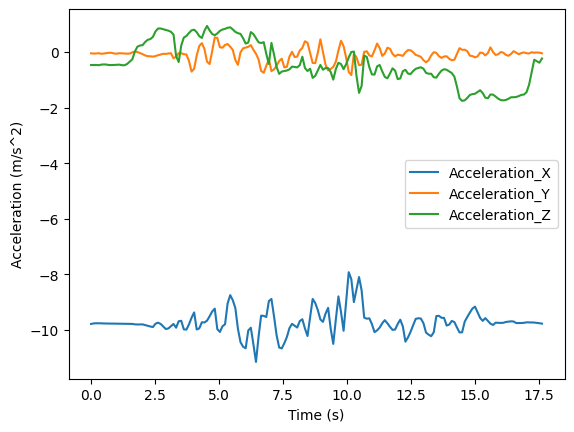

In [34]:
import matplotlib.pyplot as plt

t_axis = imu_x.x_axis

for accel_dir, letter in zip((imu_x, imu_y, imu_z), ("X", "Y", "Z")):
    plt.plot(t_axis, accel_dir, label=f"Acceleration_{letter}")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

## Interpreting and Isolating Directions

We see that the X direction experiences acceleration due to gravity. Since it negative, __the X direction must point upwards__.

We also notice that the green Z direction curve roughly matches the acceleration derived as the derivative of forward speed in ``motor_testing_april_6.ipynb``. This means that __Z is the forward direction__.

Finally, this means that Y is a side-to-side direction, and if we assume the right-hand rule applies to these axes, __Y must point to the right__ (from the driver's perspective).

### Comparing Speed Derivative with Measured Acceleration

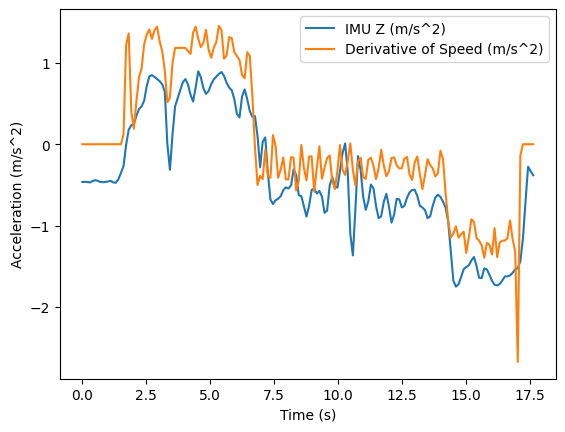

In [35]:
import numpy as np

speed_kph: TimeSeries = client.query_time_series(start_time, stop_time, "MotorRotatingSpeed")
# (kmh1 - kmh0) / period --> kmh/s
kmh_per_mps = 3.6
# acceleration is signed, meters per second squared
speed_derivative = (np.diff(speed_kph) / speed_kph.granularity) / kmh_per_mps

imu_z_aligned, speed_derivative_aligned = imu_z_raw.align(imu_z, speed_derivative)

plt.plot(t_axis, imu_z_aligned, label="IMU Z (m/s^2)")
plt.plot(t_axis, speed_derivative_aligned, label="Derivative of Speed (m/s^2)")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

### Static Measurements

When the car is stationary, the X, Y and Z acceleration each converge to a consistent value. We expect this to include gravity for X (up) but not for Y (right) and Z (forward). However, all three components have a nonzero static value.

It is possible that this is simply a bias of the sensor. However, it could be the case that we are simply seeing the effects of gravity in Y and Z because the IMU is not exactly flat. To test this, I will:
1. Use our [timestamps](https://docs.google.com/document/u/1/d/1Rx3J4bNzHDbjxchzbmqbx4wmzVHT7njctfJhgrXQq_g/edit) from today to find a time when we were stationary and on flat ground
2. Assume all static measurements are from gravity
3. Infer the true direction of "down", in which gravity is acting, within the sensor's coordinate system

Unfortunately this is not enough information to constrain a complete coordinate transformation into the car's forwards/up/right directions, but we will be halfway there.

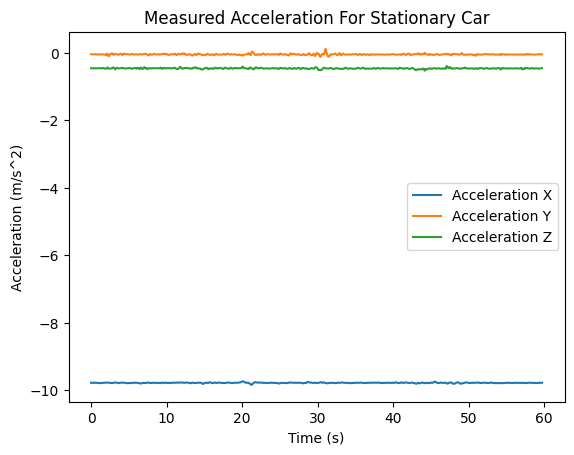

In [44]:
cruising_test_start_utc = time(14 + utc_offset_h, 56)
cruising_test_stop_utc = time(14 + utc_offset_h, 57)

start_time = datetime.combine(test_date, cruising_test_start_utc, tzinfo=timezone.utc)
stop_time = datetime.combine(test_date, cruising_test_stop_utc, tzinfo=timezone.utc)

imu_x_static_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_X")
imu_y_static_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_Y")
imu_z_static_raw: TimeSeries = client.query_time_series(start_time, stop_time, "Acceleration_Z")

imu_x_static, imu_y_static, imu_z_static = imu_x_static_raw.align(imu_x_static_raw/1000*G, imu_y_static_raw/1000*G, imu_z_static_raw/1000*G)
t_axis_static = imu_x_static.x_axis

for accel_dir, letter in zip((imu_x_static, imu_y_static, imu_z_static), ("X", "Y", "Z")):
    plt.plot(t_axis_static, accel_dir, label=f"Acceleration {letter}")
plt.title("Measured Acceleration For Stationary Car")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

In [45]:
x_static_accel = np.mean(imu_x_static)
y_static_accel = np.mean(imu_y_static)
z_static_accel = np.mean(imu_z_static)

print(f"{x_static_accel=}m/s^2")
print(f"{y_static_accel=}m/s^2")
print(f"{z_static_accel=}m/s^2")

abs_static_accel = np.sqrt(x_static_accel**2 + y_static_accel**2 + z_static_accel**2)

print(f"{abs_static_accel=}m/s^2 (expected 9.81)")

x_static_accel=TimeSeries(-9.77606084)m/s^2
y_static_accel=TimeSeries(-0.04702013)m/s^2
z_static_accel=TimeSeries(-0.46157641)m/s^2
abs_static_accel=TimeSeries(9.78706438)m/s^2 (expected 9.81)


Since z_static_accel is slightly negative, this seems to indicate that the IMU is tilted slightly forwards, such that gravity acts to pull it slightly in the +Z direction.

Because y_static_accel is quite small, I will assume that the IMU is correctly aligned in Y so that we have enough information to complete the coordinate transform.

As shown in the sketch below, I will compute $\theta$ and use it to fix the bias in the Z (forwards) reading. Note: the result of this process should be basically the same as removing the -0.46m/s^2 bias in the Z reading, but I'd still like to know what the tilt actually is, if indeed this effect is caused by a tilted IMU.

![test](imu_tilt_diagram.jpg)

In [47]:
theta = float(np.atan2(np.abs(z_static_accel), np.abs(x_static_accel)))
print(f"theta = {theta * 180 / np.pi:.4} degrees")

theta = 2.703 degrees


In [62]:
# honestly, I just figured out the sign from trial and error
xformed_imu_x_arr = np.cos(theta)*np.array(imu_x) + np.sin(theta)*np.array(imu_z)
xformed_imu_z_arr = -np.sin(theta)*np.array(imu_x) + np.cos(theta)*np.array(imu_z)
xformed_imu_x = imu_x.promote(xformed_imu_x_arr)
xformed_imu_x.meta["field"]  = "Acceleration_up"
xformed_imu_x.units = "m/s^2"
xformed_imu_z = imu_x.promote(xformed_imu_z_arr)
xformed_imu_z.meta["field"] = "Acceleration_forward"
xformed_imu_z.units = "m/s^2"

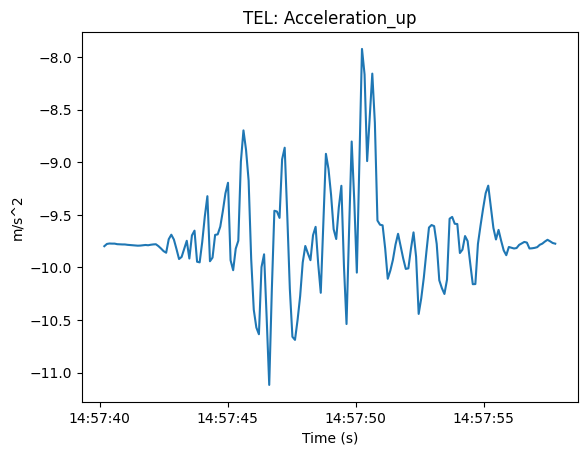

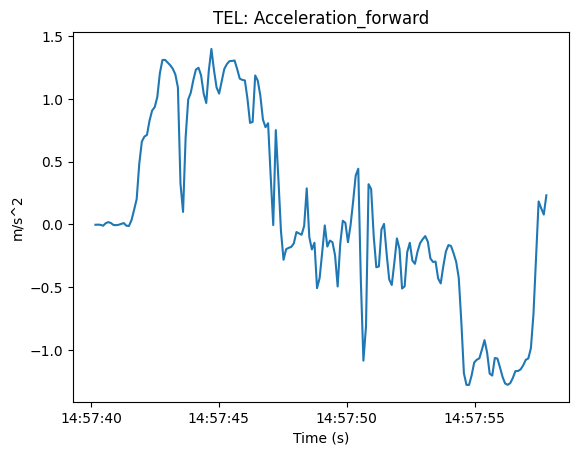

In [63]:
xformed_imu_x.plot()
xformed_imu_z.plot()

The results look okay, but let's do a sanity check:

In [66]:
# This should be around 9.81. Actually, this looks worse than before...
np.mean(xformed_imu_x)

TimeSeries(-9.72807285)

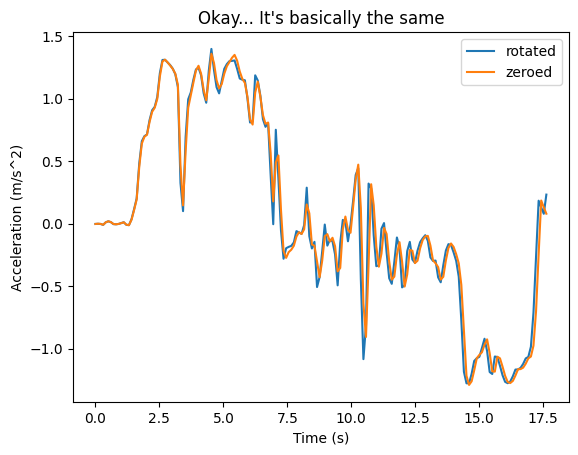

In [72]:
# let's compare the rotated x vs. just subtracting the baseline
zeroed_imu_z = imu_z_aligned - z_static_accel

plt.plot(t_axis, xformed_imu_z, label="rotated")
plt.plot(t_axis, zeroed_imu_z, label="zeroed")
plt.title("Okay... It's basically the same")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

### Static Acceleration - Conclusion

It seems the rotation doesn't provide a benefit since it is harder to do than getting the mean, and we don't really know if it's any better - we could just as well have a fixed bias, in which case subtracting the baseline makes perfect sense.

With this in mind, let's return to

### IMU vs. Speed Derivative

This time having subtracted the baseline

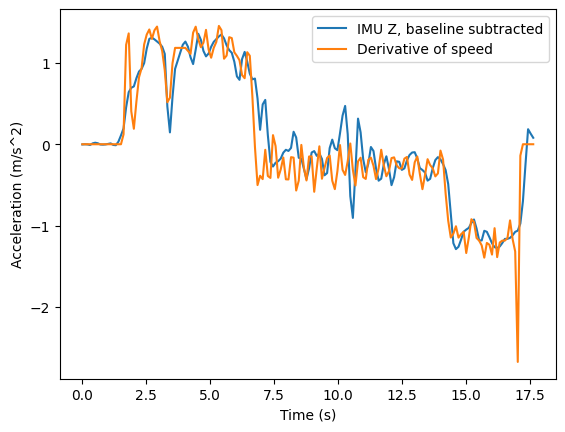

In [75]:
plt.plot(t_axis, zeroed_imu_z, label="IMU Z, baseline subtracted")
plt.plot(t_axis, speed_derivative_aligned, label="Derivative of speed")
plt.ylabel("Acceleration (m/s^2)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()